Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [37]:
PYTHONOPTIMIZE=1

from random import random, seed
from itertools import product, accumulate
import numpy as np

from matplotlib import pyplot as plt
from icecream import ic
import pandas as pd

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [27]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [28]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [30]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    if len(solution) == 0:
        return False  # No sets selected, so not valid
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))


## Have Fun!

In [31]:
# POSSIBLE TWEAK FUNCTIONS

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    mask = rng.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

def dynamic_multiple_mutation(solution: np.ndarray, strength: float) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol


## Random Mutation Hill Climber

Version A

ic| current_fitness: (np.True_, np.float64(-841093403.3498344))
ic| current_fitness: (np.True_, np.float64(-317667426.4093633))


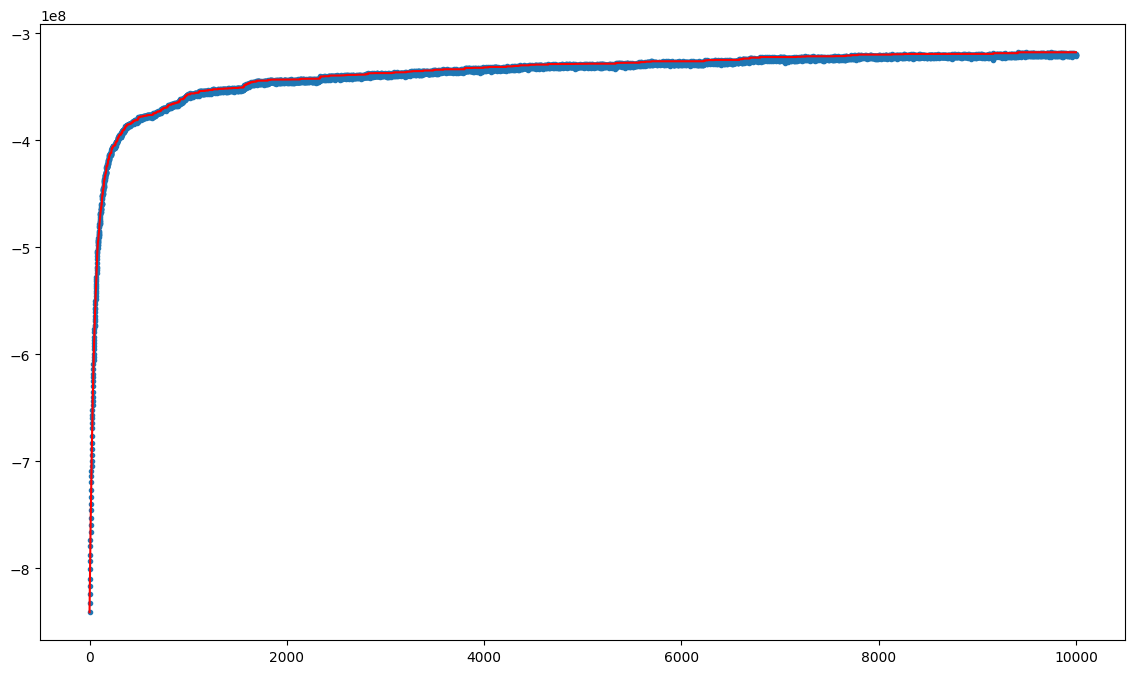

In [32]:

steps = 10_000

solution = rng.random(NUM_SETS) < 1
current_fitness = fitness(solution)
history = [float(current_fitness[1])]
ic(current_fitness)

tweak = multiple_mutation

for step in range(steps):
    new_solution = tweak(solution)
    new_fitness = fitness(new_solution)
    history.append(float(new_fitness[1]))

    if new_fitness > current_fitness:
        solution = new_solution
        current_fitness = fitness(solution)
 
ic(current_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")
None

Version B: using self-adaptive strength

ic| current_fitness: (np.True_, np.float64(-841093403.3498344))
ic| current_fitness: (np.True_, np.float64(-177775243.12834814))
ic| steps: 10000


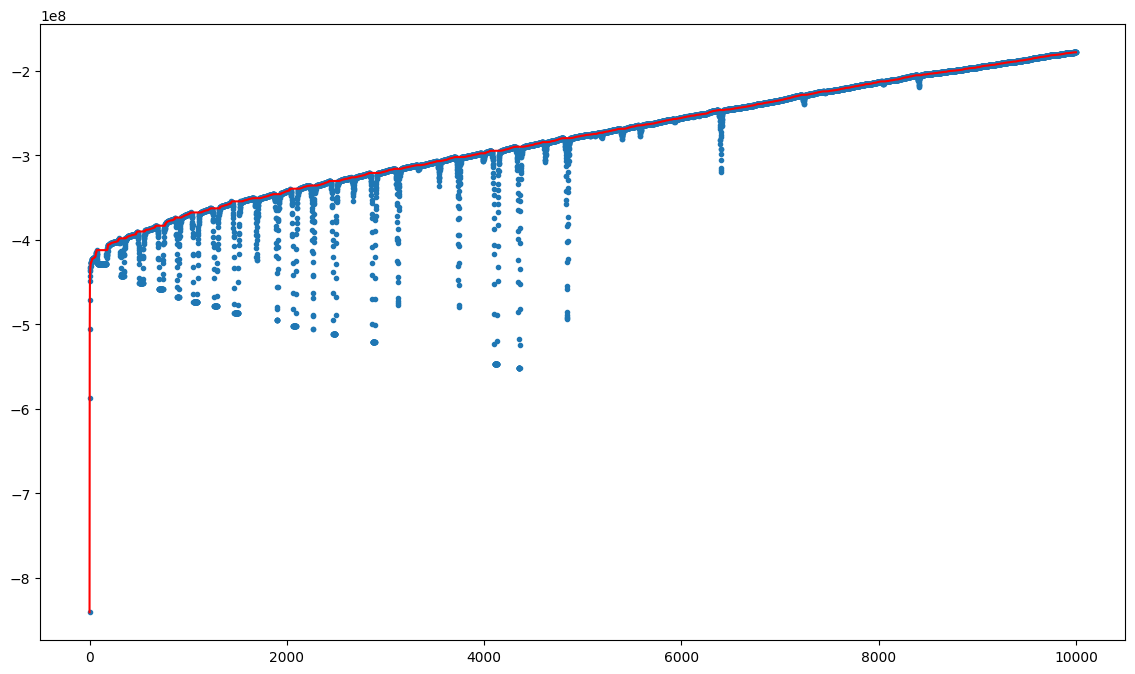

In [36]:
steps = 10_000
BUFFER_SIZE = 100

solution = rng.random(NUM_SETS) < 1
current_fitness = fitness(solution)
history = [float(current_fitness[1])]
ic(current_fitness)

strength = 0.3
buffer = list()

tweak = dynamic_multiple_mutation

for step in range(steps):
    new_solution = tweak(solution, strength)
    new_fitness = fitness(new_solution)
    history.append(float(new_fitness[1]))
    buffer.append(new_fitness > current_fitness)
    buffer = buffer[-BUFFER_SIZE:]
    
    if sum(buffer) > 25:
        #increasing
        strength *= 1.2
    elif sum(buffer) < 25:
        #decreasing
        strength /= 1.2
        
    if new_fitness > current_fitness:
        solution = new_solution
        current_fitness = fitness(solution)
 
ic(current_fitness)
ic(steps)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")
None

## Simulated Annealing

I implemented a Simulated Annealing algorithm to solve the given optimization problem, aiming to strike an effective balance between exploration and exploitation, while avoiding getting trapped in local optima. 
The algorithm has as initial solution a random one.

The process starts with a high temperature, which encourages the acceptance of worse solutions to prevent premature convergence to local optima. As the temperature decreases, the algorithm becomes more selective, favoring better solutions as it narrows down its search. The cooling schedule is designed to gradually reduce the temperature, ensuring a smooth transition from exploration to exploitation.

ic| current_fitness: (np.True_, np.float64(-841093403.3498344))
ic| current_fitness: (np.True_, np.float64(-317657843.343223))
ic| step: 9999


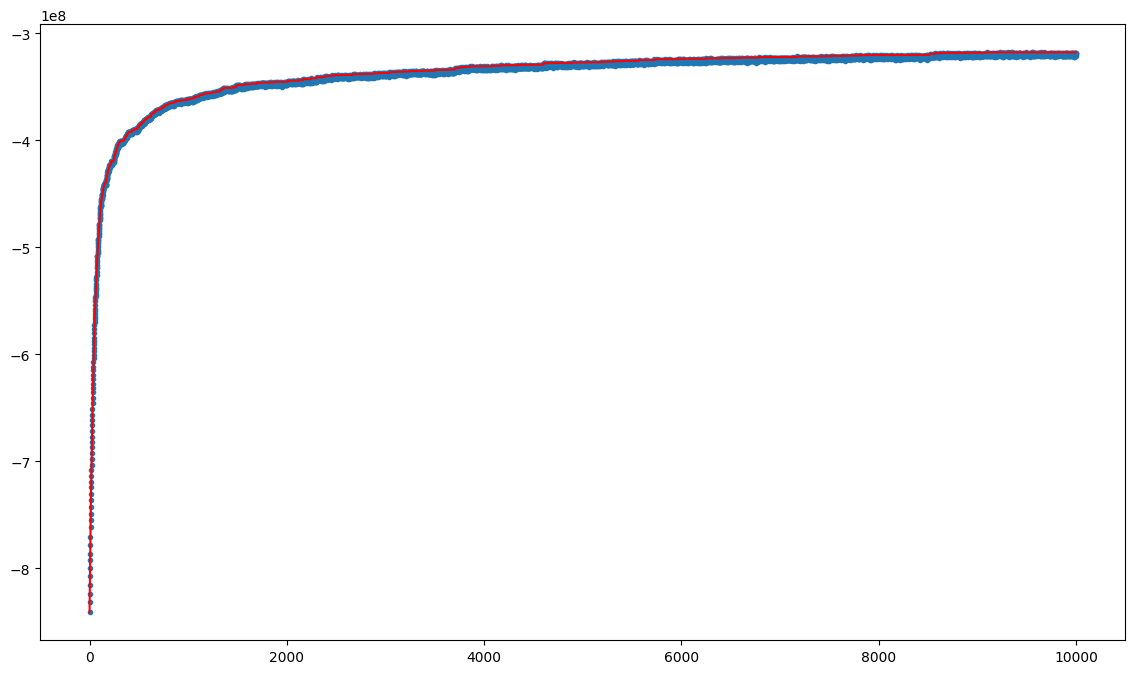

In [35]:

steps = 10_000

solution = rng.random(NUM_SETS) < 1
current_fitness = fitness(solution)
history = [float(current_fitness[1])]
ic(current_fitness)

tweak = multiple_mutation

#initial temperature -> It is better to choose an high value
initial_temp = 0.1 * -current_fitness[1] / (-np.log(0.5))

t = initial_temp

# Value used to cool the temperature
cool = 0.98

#stopping condition
stop = 1e-10


for step in range(steps):

    if t < stop:
        break

    new_solution = tweak(solution)
    new_fitness = fitness(new_solution)
    history.append(float(new_fitness[1]))

    df = current_fitness[1] - new_fitness[1]
    
    # if dt < 0 is true: the new solution is directly accepted
    # if dt > 0 is false: the new solution is worse, it can be accepted or not dipending on acceptance probability p = np.exp(- df / t)
    if df < 0 or np.random.random() < np.exp(- df / t) :
        solution = new_solution
        current_fitness = fitness(solution)
    
    #cooling the temperature
    # setting a lower bound, avoiding a p overflow
    t = max(t * cool, 1e-10)
    
ic(current_fitness)
ic(step)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")
None

In [40]:

jupiter_data = {
    "Algorithm": [
        "RMHC (A)",
        "RMHC (B)",
        "Simulated Annealing",
    ],
    "Number of steps": [
        "10_000",
        "10_000",
        "9999",
    ],
    "Best Cost": [
        "-317667426.4093633",
        "-177775243.12834814",
        "-317657843.343223",
    ]
}

# Create a DataFrame from the dictionary
jupiter_df = pd.DataFrame(jupiter_data)

# Display the table
print(jupiter_df)


             Algorithm Number of steps            Best Cost
0             RMHC (A)          10_000   -317667426.4093633
1             RMHC (B)          10_000  -177775243.12834814
2  Simulated Annealing            9999    -317657843.343223
